In [1]:
import numpy as np
from scipy.stats import special_ortho_group
import jax.numpy as jnp
from jax import grad, vmap
from Mondrian_forest import *
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import pickle

dim_in = 5
active = 2
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = jnp.dot(x, rotation)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = jnp.dot(res ** 4, projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 2000
n_test = 1000
tries = 10


x_train, _, x_test, _, _ = pickle.load(open('axis_aligned_data.pickle', 'rb'))
x_train = x_train[:, :dim_in]
x_test = x_test[:, :dim_in]

rotation = special_ortho_group.rvs(dim_in)
y_train = simulate_y(x_train, rotation)

y_test = simulate_y(x_test, rotation)


sample_range = [100, 200, 400, 800, 1600]

M = 10                      # number of Mondrian trees to use
delta = 0                   # ridge regression delta

rotation

array([[-0.40036607, -0.64825119,  0.18511046,  0.40289833, -0.4721064 ],
       [-0.808539  ,  0.32206641,  0.04514869, -0.47001056, -0.13996279],
       [ 0.30100644, -0.27478948, -0.43719254, -0.58478408, -0.54843061],
       [-0.28620886, -0.03597555, -0.87590779,  0.31802532,  0.22008108],
       [-0.11597978, -0.63185451,  0.07310223, -0.41671391,  0.63899464]])

In [2]:
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_test, rotation)
from numpy import linalg
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / n_test
norm_H = linalg.norm(true_H, ord = 2)

In [3]:
np.set_printoptions(precision=5, suppress=True)
true_H/two_one_norm(true_H)

Array([[ 1.02886,  0.07256,  0.16339,  0.21006,  0.84392],
       [ 0.07256,  1.14879, -0.52284,  0.3145 , -0.25182],
       [ 0.16339, -0.52284,  0.27562, -0.10667,  0.27949],
       [ 0.21006,  0.3145 , -0.10667,  0.12141,  0.09072],
       [ 0.84392, -0.25182,  0.27949,  0.09072,  0.77699]], dtype=float32)

In [4]:
np.linalg.matrix_rank(true_H)

2

In [5]:
def plot_trend(stats, x_axis, y_axis, title, xlabel = None, ylabel = None):
    df = pd.DataFrame(stats)

    # Prepare the data for plotting
    plot_data = [df[y_axis][i] for i in range(len(df))]

    # Create the boxplot
    plt.boxplot(plot_data, labels=[str(x[x_axis]) for x in stats])

    # Add titles and labels
    plt.title(title)
    if xlabel is None:
        xlabel = x_axis
    if ylabel is None:
        ylabel = y_axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Show the plot
    plt.show()

# Save training history

In [6]:
lifetime = 5

stats = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        y_hat_test, history, X_bd_all, w_trees = one_run(
            x_train[:n_sim, ], y_train[:n_sim, ], x_test, M, lifetime, delta
        )
        dist['history'].append([y_hat_test, history, X_bd_all, w_trees])
    stats.append(dist)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


# Get H estimate

In [7]:
def get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H):
    H_est = []
    for i in range(len(sample_range)):
        n_sim = sample_range[i]
        dist = {'n': n_sim, 'mse': [], 'H': []}
        for trial in tqdm(range(tries)):
            y_hat_test, history, X_bd_all, w_trees = \
                stats[i]['history'][trial]
            dist['mse'].append(mean_squared_error(y_test, y_hat_test))
            H_0 = estimate_H(x_train, y_train, X_bd_all, M, x_test, history, w_trees, y_hat_test)
            dist['H'].append(H_0)
        H_est.append(dist)
        
    return H_est

def estimate_H_finite_diff(x_train, y_train, X_bd_all, M, X_test, history, w_trees, y_hat_test):
    dim_in = X_test.shape[1]
    N_test = X_test.shape[0]
    importance = []
    for dim in range(dim_in):
        x_eval_pos = deepcopy(X_test)
        x_eval_neg = deepcopy(X_test)
        x_diff = 0.5
        x_eval_pos[:,dim] = x_eval_pos[:,dim] + x_diff/2
        x_eval_neg[:,dim] = x_eval_neg[:,dim] - x_diff/2
        
        y_eval_pos = evaluate(y_train, x_eval_pos, M, history, w_trees)
        y_eval_neg = evaluate(y_train, x_eval_neg, M, history, w_trees)
        y_diff = y_eval_pos - y_eval_neg
        importance_temp = y_diff/x_diff
        
        importance.append(importance_temp)
    importance = np.vstack(importance)

    H = np.matmul(importance, np.transpose(importance))/N_test
    return H

raw_H_estimates = get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H_finite_diff)

100%|██████████| 10/10 [01:26<00:00,  8.61s/it]


In [8]:
def operator_norm(H, truth):
    norm_truth = norm(truth, ord = 2)
    return norm(truth - H, ord = 2)/norm_truth

def get_eig(A):
    eigenValues, eigenVectors = linalg.eig(A)

    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenVectors

def get_angle_distance(H, truth):
    dim_proj = active
    proj = np.identity(dim_proj)
    proj = np.pad(proj, [(0, dim_in - dim_proj), (0, dim_in - dim_proj)], mode='constant')

    rank = np.linalg.matrix_rank(truth)
    
    eigenvectors = get_eig(H)
    Q_H, _ = linalg.qr(eigenvectors[:, :rank])
    
    eigenvectors = get_eig(truth)
    Q_t, _ = linalg.qr(eigenvectors[:, :rank])

    D = np.matmul(np.transpose(Q_H), Q_t)
    U, S, Vh = np.linalg.svd(D, full_matrices=True)
    S = np.minimum(S, 1)
    return np.max(np.arccos(S))

In [9]:
def plot_dist(H_estimates, title, true_H, norm_H, norm_func):
    plot_data = []
    for i in range(len(sample_range)):
        dist = H_estimates[i]
        n_sim = sample_range[i]
        alter_dist = {'n': n_sim, 'dist':[]}
        for trial in range(tries):
            H_0 = dist['H'][trial]
            alter_dist['dist'].append(norm_func(H_0, true_H))
        plot_data.append(alter_dist)
    try:
        plot_trend(plot_data, 'n', 'dist', title, ylabel='Operator distance from the True H')
    except:
        pass


def plot_H_estimates(raw_H_estimates, true_H, norm_func):

    norm_H = norm(true_H, ord = 2)
    plot_dist(raw_H_estimates, 'Unnormalised', true_H, norm_H, norm_func)

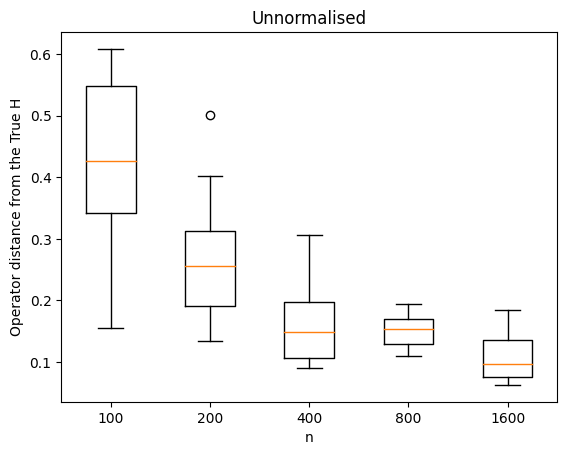

In [10]:
np.set_printoptions(precision=4)
plot_H_estimates(raw_H_estimates, true_H, get_angle_distance)

# Orginal method for estimating gradients

In [11]:
alter_H_estimates = get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H_ind)

100%|██████████| 10/10 [00:51<00:00,  5.13s/it]


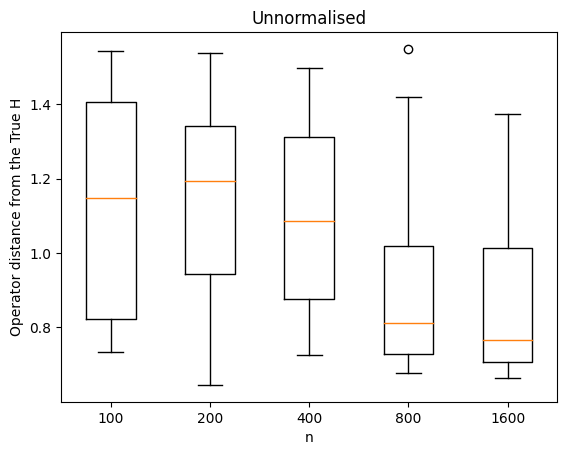

In [12]:
plot_H_estimates(alter_H_estimates, true_H, get_angle_distance)

In [13]:
lifetime_max = 5
n_sim = 1600
results = []
results.append(
    evaluate_all_lifetimes(x_train[:n_sim,], 
                           y_train[:n_sim], 
                           x_test, y_test, M, lifetime_max, delta))

In [14]:
x_train_transformed, x_test_transformed = transform_data(true_H/two_one_norm(true_H), x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

In [15]:
H_1 = raw_H_estimates[4]['H'][0]/two_one_norm(raw_H_estimates[4]['H'][0])

x_train_transformed, x_test_transformed = transform_data(H_1, x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

In [16]:
# subset results[0][0]['times'] whose indices mod 10 == 0

def process_times(times):
    return [times[i] for i in range(len(times)) if i % 10 == 0]

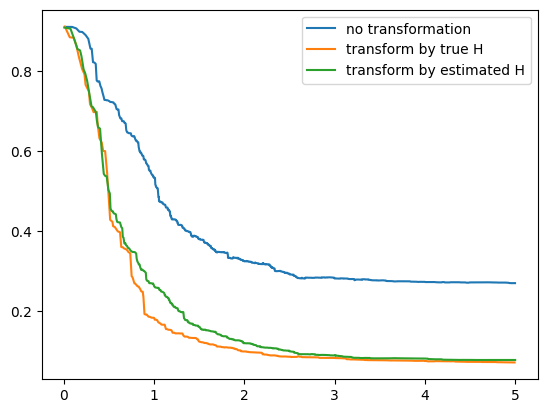

In [17]:
plt.plot(process_times(results[0][0]['times']), results[0][0]['mse'], label = 'no transformation')
plt.plot(process_times(results[1][0]['times']), results[1][0]['mse'], label = 'transform by true H')
plt.plot(process_times(results[2][0]['times']), results[2][0]['mse'], label = 'transform by estimated H')
plt.legend()

In [18]:
raw_H_estimates[4]['H'][0]

array([[ 0.8914,  0.1128,  0.0285,  0.1471,  0.4223],
       [ 0.1128,  1.0707, -0.4189,  0.2047, -0.1627],
       [ 0.0285, -0.4189,  0.4667, -0.0913,  0.131 ],
       [ 0.1471,  0.2047, -0.0913,  0.3199,  0.0667],
       [ 0.4223, -0.1627,  0.131 ,  0.0667,  0.7398]], dtype=float32)

In [19]:
H_1

array([[ 1.077 ,  0.1363,  0.0344,  0.1777,  0.5102],
       [ 0.1363,  1.2936, -0.5061,  0.2473, -0.1965],
       [ 0.0344, -0.5061,  0.5638, -0.1103,  0.1582],
       [ 0.1777,  0.2473, -0.1103,  0.3865,  0.0806],
       [ 0.5102, -0.1965,  0.1582,  0.0806,  0.8938]], dtype=float32)

In [20]:
true_H/two_one_norm(true_H)

Array([[ 1.0289,  0.0726,  0.1634,  0.2101,  0.8439],
       [ 0.0726,  1.1488, -0.5228,  0.3145, -0.2518],
       [ 0.1634, -0.5228,  0.2756, -0.1067,  0.2795],
       [ 0.2101,  0.3145, -0.1067,  0.1214,  0.0907],
       [ 0.8439, -0.2518,  0.2795,  0.0907,  0.777 ]], dtype=float32)

In [21]:
stats = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        y_hat_test, history, X_bd_all, w_trees = one_run(
            x_train_transformed[:n_sim, ], y_train[:n_sim, ], x_test_transformed, M, lifetime, delta
        )
        dist['history'].append([y_hat_test, history, X_bd_all, w_trees])
    stats.append(dist)

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:59<00:00,  5.95s/it]


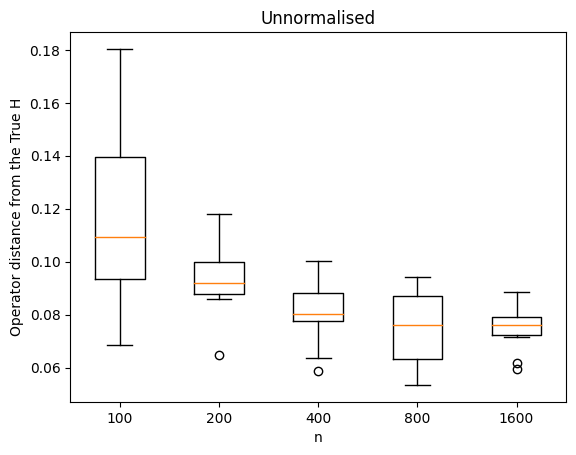

In [22]:
raw_H_estimates = get_H_estimates(stats, x_train_transformed, x_test_transformed, y_test, M, delta, estimate_H_finite_diff)

def get_angle_distance_1(H, truth):
    return get_angle_distance(np.matmul(H_1, H), truth)

plot_H_estimates(raw_H_estimates, true_H, get_angle_distance_1)

In [23]:
H_2 = raw_H_estimates[4]['H'][0]/two_one_norm(raw_H_estimates[4]['H'][0])

x_train_transformed, x_test_transformed = transform_data(H_2, 
                                                         x_train_transformed, x_test_transformed)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

In [24]:
H_12 = np.matmul(H_1, H_2)
H_12

array([[ 1.3204,  0.2585,  0.2645,  0.5619,  1.1384],
       [ 0.1698,  1.313 , -0.9942,  0.895 , -0.3741],
       [ 0.1144, -0.6741,  0.6677, -0.4232,  0.3975],
       [ 0.3416,  0.4189, -0.2285,  0.438 ,  0.1635],
       [ 1.0306, -0.2067,  0.5577,  0.1891,  1.1621]], dtype=float32)

In [25]:
true_H/two_one_norm(true_H)

Array([[ 1.0289,  0.0726,  0.1634,  0.2101,  0.8439],
       [ 0.0726,  1.1488, -0.5228,  0.3145, -0.2518],
       [ 0.1634, -0.5228,  0.2756, -0.1067,  0.2795],
       [ 0.2101,  0.3145, -0.1067,  0.1214,  0.0907],
       [ 0.8439, -0.2518,  0.2795,  0.0907,  0.777 ]], dtype=float32)

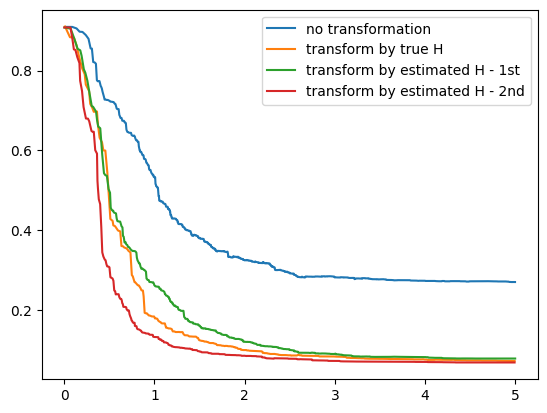

In [26]:
plt.plot(process_times(results[0][0]['times']), results[0][0]['mse'], label = 'no transformation')
plt.plot(process_times(results[1][0]['times']), results[1][0]['mse'], label = 'transform by true H')
plt.plot(process_times(results[2][0]['times']), results[2][0]['mse'], label = 'transform by estimated H - 1st')
plt.plot(process_times(results[3][0]['times']), results[3][0]['mse'], label = 'transform by estimated H - 2nd')
plt.legend()

In [27]:
stats = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        y_hat_test, history, X_bd_all, w_trees = one_run(
            x_train_transformed[:n_sim, ], y_train[:n_sim, ], x_test_transformed, M, lifetime, delta
        )
        dist['history'].append([y_hat_test, history, X_bd_all, w_trees])
    stats.append(dist)

100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:34<00:00,  3.46s/it]


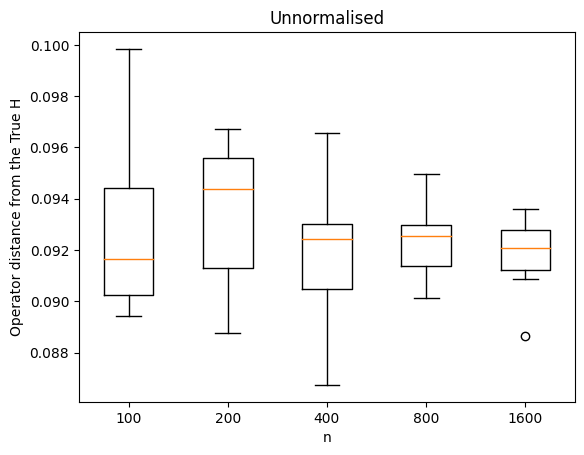

In [28]:
raw_H_estimates = get_H_estimates(stats, x_train_transformed, x_test_transformed, y_test, M, delta, estimate_H_finite_diff)

def get_angle_distance(H, truth):
    dim_proj = active
    proj = np.identity(dim_proj)
    proj = np.pad(proj, [(0, dim_in - dim_proj), (0, dim_in - dim_proj)], mode='constant')

    rank = np.linalg.matrix_rank(truth)
    
    eigenvectors = get_eig(H)
    Q_H, _ = linalg.qr(eigenvectors[:, :rank])
    
    eigenvectors = get_eig(truth)
    Q_t, _ = linalg.qr(eigenvectors[:, :rank])

    D = np.matmul(np.transpose(Q_H), Q_t)
    U, S, Vh = np.linalg.svd(D, full_matrices=True)
    S = np.minimum(S, 1)
    return np.max(np.arccos(S))

def get_angle_distance_12(H, truth):
    return get_angle_distance(np.matmul(H_12, H), truth)

plot_H_estimates(raw_H_estimates, true_H, get_angle_distance_12)

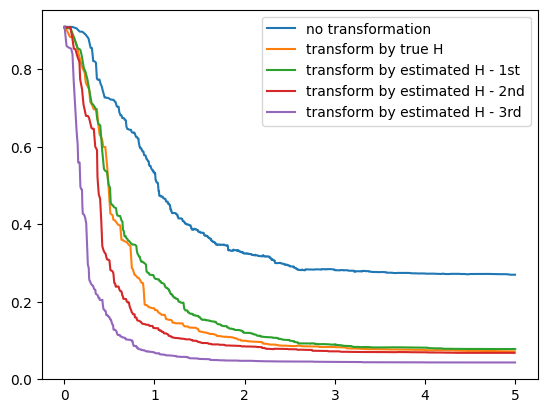

In [29]:
H_3 = raw_H_estimates[4]['H'][0]/two_one_norm(raw_H_estimates[4]['H'][0])
x_train_transformed, x_test_transformed = transform_data(H_3, 
                                                         x_train_transformed, x_test_transformed)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

plt.plot(process_times(results[0][0]['times']), results[0][0]['mse'], label = 'no transformation')
plt.plot(process_times(results[1][0]['times']), results[1][0]['mse'], label = 'transform by true H')
plt.plot(process_times(results[2][0]['times']), results[2][0]['mse'], label = 'transform by estimated H - 1st')
plt.plot(process_times(results[3][0]['times']), results[3][0]['mse'], label = 'transform by estimated H - 2nd')
plt.plot(process_times(results[4][0]['times']), results[4][0]['mse'], label = 'transform by estimated H - 3rd')
plt.legend()

In [32]:
H_123 = np.matmul(H_12, H_3)

H_123/two_one_norm(H_123)

array([[ 0.8012,  0.2625,  0.2856,  0.4196,  0.7114],
       [ 0.0435,  0.9585, -0.5092,  0.6724, -0.2128],
       [ 0.1116, -0.4995,  0.344 , -0.3131,  0.2436],
       [ 0.2002,  0.3408, -0.0825,  0.2996,  0.105 ],
       [ 0.6739, -0.0932,  0.4173,  0.1372,  0.6883]], dtype=float32)

In [31]:
true_H/two_one_norm(true_H)

Array([[ 1.0289,  0.0726,  0.1634,  0.2101,  0.8439],
       [ 0.0726,  1.1488, -0.5228,  0.3145, -0.2518],
       [ 0.1634, -0.5228,  0.2756, -0.1067,  0.2795],
       [ 0.2101,  0.3145, -0.1067,  0.1214,  0.0907],
       [ 0.8439, -0.2518,  0.2795,  0.0907,  0.777 ]], dtype=float32)